# 1. Описание датасета и постановка задачи

## Задача

Реализовать модель для предсказания стоимости автомобиля

Метрика - MAPE

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

## Описание полей данных

- Date: Год выпуска автомобиля.
- Make: Марка автомобиля.
- Model: издание автомобиля определенной марки.
- Trim: Уровни отделки салона автомобиля — это просто разные версии модели.
- Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- Transmission: механизм, который передает мощность от двигателя к колесам.
- VIN: идентификационный номер транспортного средства.
- State: состояние, в котором автомобиль выставлен на аукцион.
- Condition: Состояние автомобилей на момент аукциона.
- Odometer: расстояние, пройденное автомобилем с момента выпуска.
- Color: Цвет кузова автомобиля.
- Interior: Цвет салона автомобиля.
- Seller: Продавец автомобиля, автосалоны.
- mmr: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.
- sellingprice: цена, по которой автомобиль был продан на аукционе.
- saledate: Дата продажи автомобиля.

## 2. Импортируем необходимые библиотеки и загружаем данные

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from catboost import CatBoostRegressor, Pool

from tensorflow import keras
from keras import callbacks
from keras.optimizers import Adam

In [77]:
RANDOM_STATE = 123

## 2.1. Загружаем данные

In [4]:
try:
    df = pd.read_csv('./data/train.csv')
except FileNotFoundError:
    print("File not found."

In [5]:
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


**Размер данных**

In [80]:
df.shape

(440236, 15)

**Информация о распределении и типах признаков в датафрейме**

In [81]:
df.describe()

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


**Проверяем на полные дубликаты**

In [83]:
df.duplicated().sum()

0

## 2.2. Проверяем на наличие пропусков

In [84]:
df.isna().mean()[df.isna().mean() > 0]

make            0.018270
model           0.018451
trim            0.018938
body            0.023608
transmission    0.116894
condition       0.021364
odometer        0.000157
color           0.001331
interior        0.001331
dtype: float64

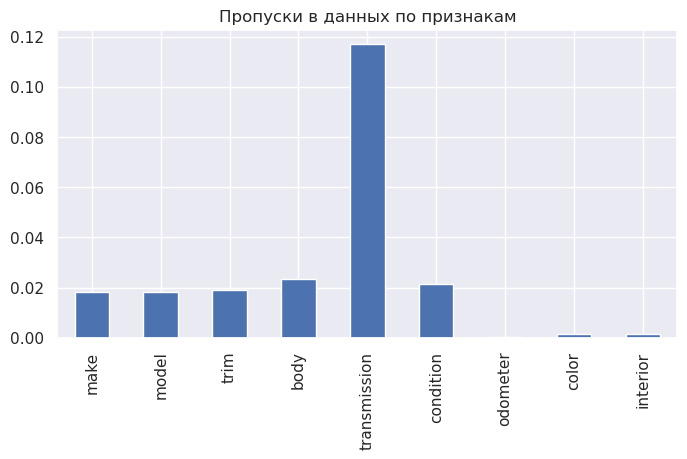

In [85]:
plt.figure(figsize = (8, 4))
df.isna().mean()[df.isna().mean() > 0].plot(kind='bar', grid=True)
plt.title('Пропуски в данных по признакам')
plt.show()

# 3. Создаем новые признаки и заполняем пропуски

## 3.1. Создаем признаки из VIN номера

In [86]:
def extract_features_date_vin(data: pd.DataFrame) -> pd.DataFrame:
    
    
        def date_type_cast(data: pd.DataFrame) -> pd.DataFrame:

            data['saledate'] = pd.to_datetime(data['saledate'].str[4:24], utc=True)
            data['dayofweek'] = data['saledate'].dt.dayofweek
            data['year_sale'] = data['saledate'].dt.year
            data['month_sale'] = data['saledate'].dt.month
            data['years_of_car'] = data['year_sale'] - data['year']

            return data
        
        def transform_lower(data: pd.DataFrame) -> pd.DataFrame:

            data['make'] = data['make'].str.lower()
            data['model'] = data['model'].str.lower()
            data['trim'] = data['trim'].str.lower()
            data['body'] = data['body'].str.lower()
            data['seller'] = data['seller'].str.lower()
            return data

    
        def parsing_vin_number(data: pd.DataFrame) -> pd.DataFrame:
            data['region'] = data['vin'].str[0]
            data['country'] = data['vin'].str[1]
            data['manufacture'] = data['vin'].str[1:3]
            data['model_code'] = data['vin'].str[4:6]
            data['wheelbase'] = data['vin'].str[6]
            data['body_type'] = data['vin'].str[7]
            data['production_year'] = data['vin'].str[9]
            data['producation_plant'] = data['vin'].str[10]
            return data

        data = transform_lower(data)
        data = date_type_cast(data)
        data = parsing_vin_number(data)
        
        return data

In [87]:
df = extract_features_date_vin(df)
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,month_sale,years_of_car,region,country,manufacture,model_code,wheelbase,body_type,production_year,producation_plant
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,6,4,2,f,fm,k3,j,c,b,b
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,2,1,3,f,fa,p0,h,7,e,r
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,6,3,3,n,n1,b6,a,p,c,l
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,6,12,5,g,gr,n2,3,u,3,h
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,...,2,8,3,f,fa,p0,8,z,7,r


Выделили дополнительные признаки из даты и vin номера

## 3.2. Заполняем пропуски

Создадим функцию для заполнения пропусков

In [88]:
def fill_na_features(data: pd.DataFrame) -> pd.DataFrame:
    
    
        #Model
        def model_fill_na_values(data: pd.DataFrame) -> pd.DataFrame:

            #1 шаг заполнения пропусков Model
            temp_df = data[['model', 'manufacture', 'model_code']].groupby(['manufacture','model_code'])['model'] \
                                                                            .first().to_frame()
            transform_model = lambda s: temp_df.loc[(s['manufacture'], s['model_code'])]
            data.loc[data.model.isna(), 'model'] = data[data.model.isna()].apply(transform_model, axis=1)
            
            #2 шаг заполнения пропусков Model
            temp_df = data[['model', 'model_code']].groupby(['model_code'])['model'] \
                                                                             .first().to_frame()
            transform_model = lambda s: temp_df.loc[(s['model_code'])]
            data.loc[data.model.isna(), 'model'] = data[data.model.isna()].apply(transform_model, axis=1)

            
            #3 шаг заполнения пропусков Model
            temp_df = data[['model', 'manufacture']].groupby(['manufacture'])['model'] \
                                                                                         .first().to_frame()

            transform_model = lambda s: temp_df.loc[(s['manufacture'])]
            data.loc[data.model.isna(), 'model'] = data[data.model.isna()].apply(transform_model, axis=1)
            
            return data
        
        #Body  
        def body_fill_na_values(data: pd.DataFrame) -> pd.DataFrame:
            
            data['body'] = data['body'].str.replace(' ', '_')
            data['body'] = data['body'].str.replace('-', '_')
            
            #Уменьшим количество категорий в Body
            body_dict = {"koup" : "coupe",
                     "q60_coupe": "coupe",
                     "q60_convertible": "convertible",
                     "g37_convertible": "convertible",
                     "cts_v_wagon": "wagon",
                     "cab_plus": "cab_plus",
                     "cab_plus_4" : "cab_plus",
                     "cts_coupe": "coupe",
                     "g37_coupe": "coupe",
                     "elantra_coupe": "coupe",
                     "transit_van": "van",
                     "cts_v_coupe": "coupe",
                     "cts_wagon": "wagon", 
                     "g_sedan": "sedan",
                     "ram_van": "van",
                     "granturismo_convertible": "convertible",
                     "regular_cab": "cab",
                     "crewmax_cab": "crew_cab",
                     "g_coupe": "coupe",
                     "e_series_van": "van",
                     "double_cab": "cab",
                     "king_cab": "king_cab",
                     "xtracab": "cab",
                     "quad_cab": "cab",
                     "extended_cab": "extended_cab",
                     "beetle_convertible": "convertible",
                     "tsx_sport_wagon": "wagon",
                     "g_convertible": "convertible",
                     "promaster_cargo_van": "van",
                     "genesis_coupe": "coupe",
                     "club_cab": "cab",
                     "access_cab": "cab",
                     "mega_cab": "king_cab",
                     "crew_cab": "cab",
                     "cab_plus": "cab"
                    }

            data['body'] = data['body'].map(body_dict).fillna(data['body'])
            data['body'] = data['body'].fillna('other')

            return data
        
        
        #Condition
        def condition_fill_na_values(data: pd.DataFrame) -> pd.DataFrame:
            temp_df = data[['year','model_code','condition']].groupby(['year','model_code'])['condition'].median().to_frame()
            
            def transform_model(s):
                return temp_df.loc[(s['year'],s['model_code'])]
            
            data.loc[data.condition.isna(), 'condition'] = data[data.condition.isna()].apply(transform_model, axis=1)
            
            return data


        #Condition
        data['condition'] = data['condition'].fillna(data['condition'].median())
        
        def odometer_fill_na_values(data: pd.DataFrame) -> pd.DataFrame:
    
            temp_df = df[['year','model_code','odometer']].groupby(['year','model_code'])['odometer'] \
                                                                                    .median().to_frame()
            transform_odometer = lambda s: temp_df.loc[(s['year'],s['model_code'])]
            data.loc[data.odometer.isna(), 'odometer'] = data[data.odometer.isna()].apply(transform_odometer, axis=1)    

            return data
        
        #Transmission
        def transmission_fill_na_values(data: pd.DataFrame) -> pd.DataFrame:

            temp_df = data[['year','model_code','transmission']].groupby(['year','model_code']) \
                                                                        ['transmission'].first().to_frame()
            transform_transmission = lambda s: temp_df.loc[(s['year'],s['model_code'])]
            data.loc[data.transmission.isna(), 'transmission'] = data[data.transmission.isna()] \
                                                                    .apply(transform_transmission, axis=1)    

            return data
        
        
        data = model_fill_na_values(data)
        data = odometer_fill_na_values(data)
        data = body_fill_na_values(data)
        data = condition_fill_na_values(data)
        data = transmission_fill_na_values(data)
   
        #Transmission
        data['transmission'] = data['transmission'].fillna(data['transmission'].value_counts().head(1).index[0])
        
        #Color
        data['color'] = data['color'].fillna(data['color'].value_counts().head(1).index[0])
        
        #Interior
        data['interior'] = data['interior'].fillna(data['interior'].value_counts().head(1).index[0])
        
        #Trim
        data['trim'] = data['trim'].fillna('other')
        
        #Make
        data['make'] = data['make'].fillna('other')
        
        return data

In [89]:
df = fill_na_features(df)

In [90]:
df.isna().mean()[df.isna().mean() > 0]

Series([], dtype: float64)

Заполнили все пропуски



## 3.3. Создаем дополнительные признаки

In [91]:
def feaute_eng(data: pd.DataFrame) -> pd.DataFrame:
            
        #Create odometer log feature and odometer per year
        def odometer_feature (data: pd.DataFrame) -> pd.DataFrame:

            data['odometer_log'] = np.log2(data['odometer'])

            data['odometer_per_year'] = data['odometer']/(data['year_sale'] - data['year'] + 2)

            return data
    
        #Create feature car sell fin type
        def create_fin_type(data: pd.DataFrame) -> pd.DataFrame:

            t = ['financial', 'credit', 'bank', 'lease', 'rent', 'sales', 'business', 'used', 'auction']
            
            for i in t:
                data.loc[data['seller'].str.contains(i, case=False), ['fin_type']] = i

            data['fin_type'] = data['fin_type'].fillna('no_info')
            return data
        
        
        def ad_feature_gr(data: pd.DataFrame) -> pd.DataFrame:
            
            #Expensive cars
            t = ['sport', 'premium', 'executive', 'special','rental', 'premium', 'supersports', 'super', 'spyder', 'GT',
                 'g500', '740li', '850i', 'leather','alpina', 'w/prem']
            for i in t:
                data.loc[data['trim'].str.contains(i, case=False), ['expensive_type']] = i

            data['expensive_type'] = data['expensive_type'].fillna('other')

            #Engine_capacity
            t_e_c = set([
                 '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0', '2.1',
                 '2.2', '2.3', '2.4', '2.5', '2.7', '2.8', '2.9', '3.0', '3.1', '3.2', '3.5', '3.6', '3.8'
                 '4.0', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9',
                 '5.0', '5.1', '5.2',
                 '6.0', '6.1', '6.2',
                 '35', '37',
                 '200', '210', '220', '250', '270', '280', '290',
                 '300', '310', '320', '330', '340',
                 '420', '427', '430', '450', '470',
                 '500', '550', '525', '535',
                 '740', '750', '850',
                 '1500', '1794', '2500', '3500',
                 '60'
                 ])
            
            data['engine_capacity'] = 'other'
            for i in t_e_c:
                data.loc[data['trim'].str.contains(i, case=False), ['engine_capacity']] = i

            data['engine_capacity'] = data['engine_capacity'].fillna('other')
            
            
           # data['engine_capacity'] = data['trim'].str.extract('(^[\.0-9]*$)', expand=False)
           # data['engine_capacity'] = data['engine_capacity'].fillna('other')


            #Engine_type
            t =  ['v4', 'v5', 'v6', 'v8', 'v10', 'v12', 'w4', 'w6', 'w8', 'w10', 'w12']
            
            for i in t:
                data.loc[data['trim'].str.contains(i, case=False), ['engine_type']] = i
                
            data['engine_type'] = data['engine_type'].fillna('other')


            #Electric
            t = ['elec', 'hybrid']
            for i in t:
                data.loc[data['trim'].str.contains(i, case=False), ['electric']] = i

            data['electric'] = data['electric'].fillna('other')

            #All road
            t = ['4x4', 'awd', 'fwd', 'off/rd', 'quattro', '4matic', '4motion', '4MATIC', 'xdrive', 'cherokee']
            for i in t:
                data.loc[data['trim'].str.contains(i, case=False), ['four_wheel_drive']] = i

            data['four_wheel_drive'] = data['four_wheel_drive'].fillna('0')

            #Van Track
            t = ['van', 'truck', 'truck', 'cargo']
            for i in t:
                data.loc[data['trim'].str.contains(i, case=False), ['van']] = i
            
            data['van'] = data['van'].fillna('other')

            return data
        
        #Clear trim
        def trim_clear(data: pd.DataFrame) -> pd.DataFrame:
            
            data['trim_clear'] = data['trim'].str.extract('(^\.?(?:\d+|[a-z]+)(?:\.(?:\d+|[a-z]+))*\.?$)', expand=False) \
                                                                    .str.strip()
            data['trim_clear'] = data['trim_clear'].fillna('other')

            return data
        
        def seller_clear(data: pd.DataFrame) -> pd.DataFrame:
            
            #top seller # df.seller.value_counts().head(25)
            s = set(['avis','luxury','santander','hertz',
                 'budget', 'tdaf', 'jpmorgan', 'department',
                 'enterprise', 'remarketing', 'wells fargo', 'gm financial',
                 'lease plan', 'ge fleet', 'dtg operations', 'capital one'
                 'wheels exchange', 'capital one', 'world omni', 'wheels exchange','u-haul'
                 'fiserv', 'adcock', 'ari'])
        
        
            l = set(list(data['make'].str.lower().value_counts().index))     
            l.update(s)
            for i in l:
                data.loc[df['seller'].str.contains(i, case=False), ['seller_cast']] = i
            
            data['seller_cast'] = data['seller_cast'].fillna('other')
            
            return data

        

        data = odometer_feature(data)
        data = create_fin_type(data)
        data = ad_feature_gr(data)
        data = trim_clear(data)
        data = seller_clear(data)
        
        
        return data

In [92]:
df = feaute_eng(df)

**Создали признаки:**

 - odometer_log - логарифм от пробега, чтобы распределение пробега было нормальным
 - odometer_per_year - пробег за год
 - fin_type - тип продажи у продавца
 - expensive_type - категории дорогих автомобилей
 - engine_capacity - объем двигателя
 - engine_type - тип двигателя
 - four_wheel_drive - полный привод
 - electric - электрический, гибридный автомобиль
 - van - признак грузового автомобиля
 - seller_cast - очищенные продавцы

**Приведем к типам числовые признаки**


In [93]:
def cast_to_type(data: pd.DataFrame) -> pd.DataFrame:
    
    data['year'] = data['year'].astype('int16')
    data['year_sale'] = data['year_sale'].astype('int16')
    data['dayofweek'] = data['dayofweek'].astype('int16')
    data['condition'] = data['condition'].astype('float32')
    data['odometer_log'] = data['odometer_log'].astype('float32')
    data['odometer_per_year'] = data['odometer_per_year'].astype('float32')
    data['odometer'] = data['odometer'].astype('float32')
    data['month_sale'] = data['month_sale'].astype('int16')
    data['years_of_car'] = data['years_of_car'].astype('int16')
    
    return data

In [94]:
df = cast_to_type(df)

# 4. EDA

## 4.1. Распределение таргета

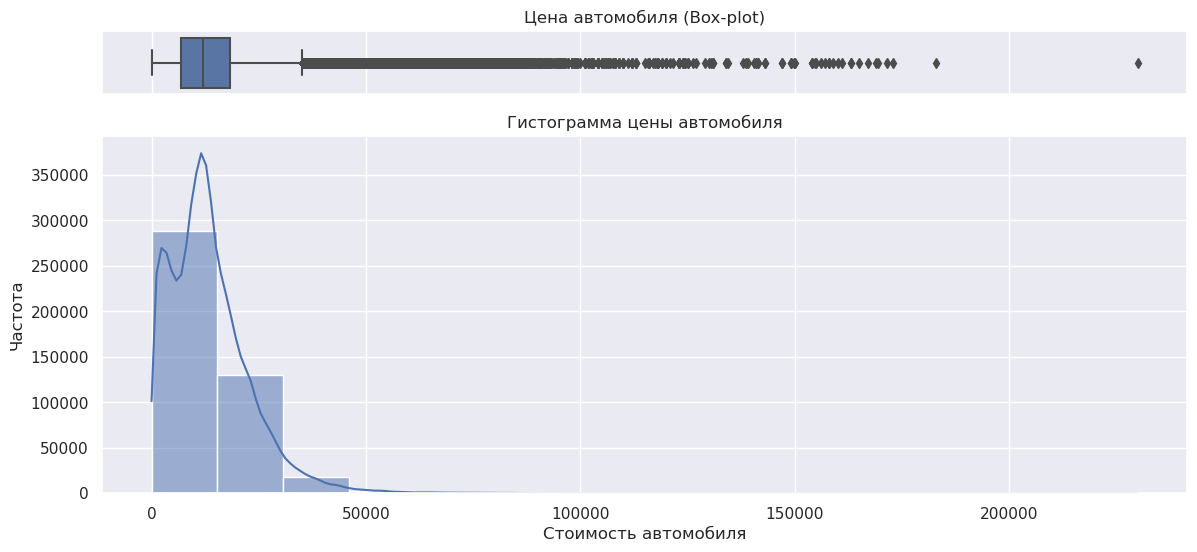

In [95]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex = True, figsize=(14,6), gridspec_kw = {'height_ratios': (.15, .85)})

sns.boxplot(x = df['sellingprice'], ax = ax_box)
sns.histplot(x = df['sellingprice'], ax = ax_hist, bins = 15, kde = True)

ax_box.set(xlabel = '')
ax_hist.set(ylabel = 'frequency')
ax_box.set_title('Цена автомобиля (Box-plot)')
ax_hist.set_title('Гистограмма цены автомобиля')
ax_hist.set_xlabel('Стоимость автомобиля')
ax_hist.set_ylabel('Частота')

plt.show()

Прологарифмируем таргет

In [96]:
df['sellingprice_log'] = np.log(df['sellingprice'])

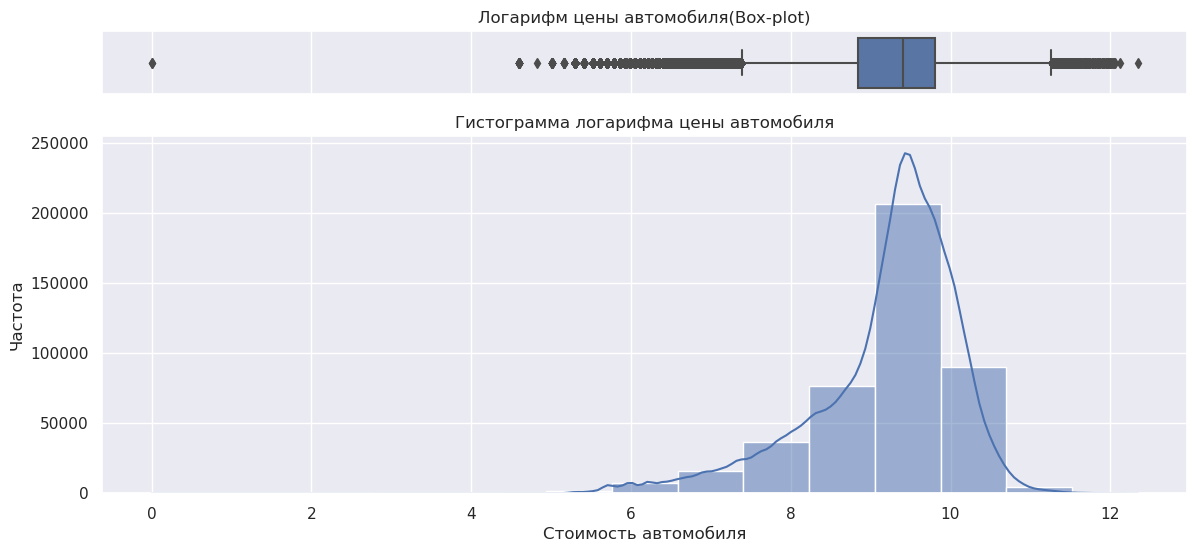

In [97]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex = True, figsize=(14,6), gridspec_kw = {'height_ratios': (.15, .85)})

sns.boxplot(x = df['sellingprice_log'], ax = ax_box)
sns.histplot(x = df['sellingprice_log'], ax = ax_hist, bins = 15, kde = True)

ax_box.set(xlabel = '')
ax_hist.set(ylabel = 'frequency')
ax_box.set_title('Логарифм цены автомобиля(Box-plot)')
ax_hist.set_title('Гистограмма логарифма цены автомобиля')
ax_hist.set_xlabel('Стоимость автомобиля')
ax_hist.set_ylabel('Частота')

plt.show()

Распределение зависимой переменной стало близко к нормальному. Моделям легче работать с целевым признаком распределенным нормально.

## 4.2. Анализ числовых признаков

In [98]:
numeric_features = df.select_dtypes(include=['float32','int16','int64'])

In [99]:
numeric_features

,year,condition,odometer,sellingprice,dayofweek,year_sale,month_sale,years_of_car,odometer_log,odometer_per_year
0,2011,4.2,111041.0,12500,1,2015,6,4,16.760733,18506.833984
1,2014,3.5,31034.0,14500,2,2015,2,1,14.921562,10344.666992
2,2012,2.2,35619.0,9100,2,2015,6,3,15.120359,7123.799805
3,2003,2.8,131301.0,13300,2,2015,6,12,17.002518,9378.642578
4,2007,2.0,127709.0,1300,1,2015,2,8,16.962502,12770.900391
...,...,...,...,...,...,...,...,...,...,...
440231,2013,4.5,20434.0,16000,1,2015,1,2,14.318684,5108.500000
440232,2014,2.9,14675.0,24250,2,2015,2,1,13.841073,4891.666504
440233,2008,3.7,102552.0,16750,1,2015,3,7,16.645996,11394.666992
440234,2014,3.0,29367.0,33000,2,2015,1,1,14.841908,9789.000000


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


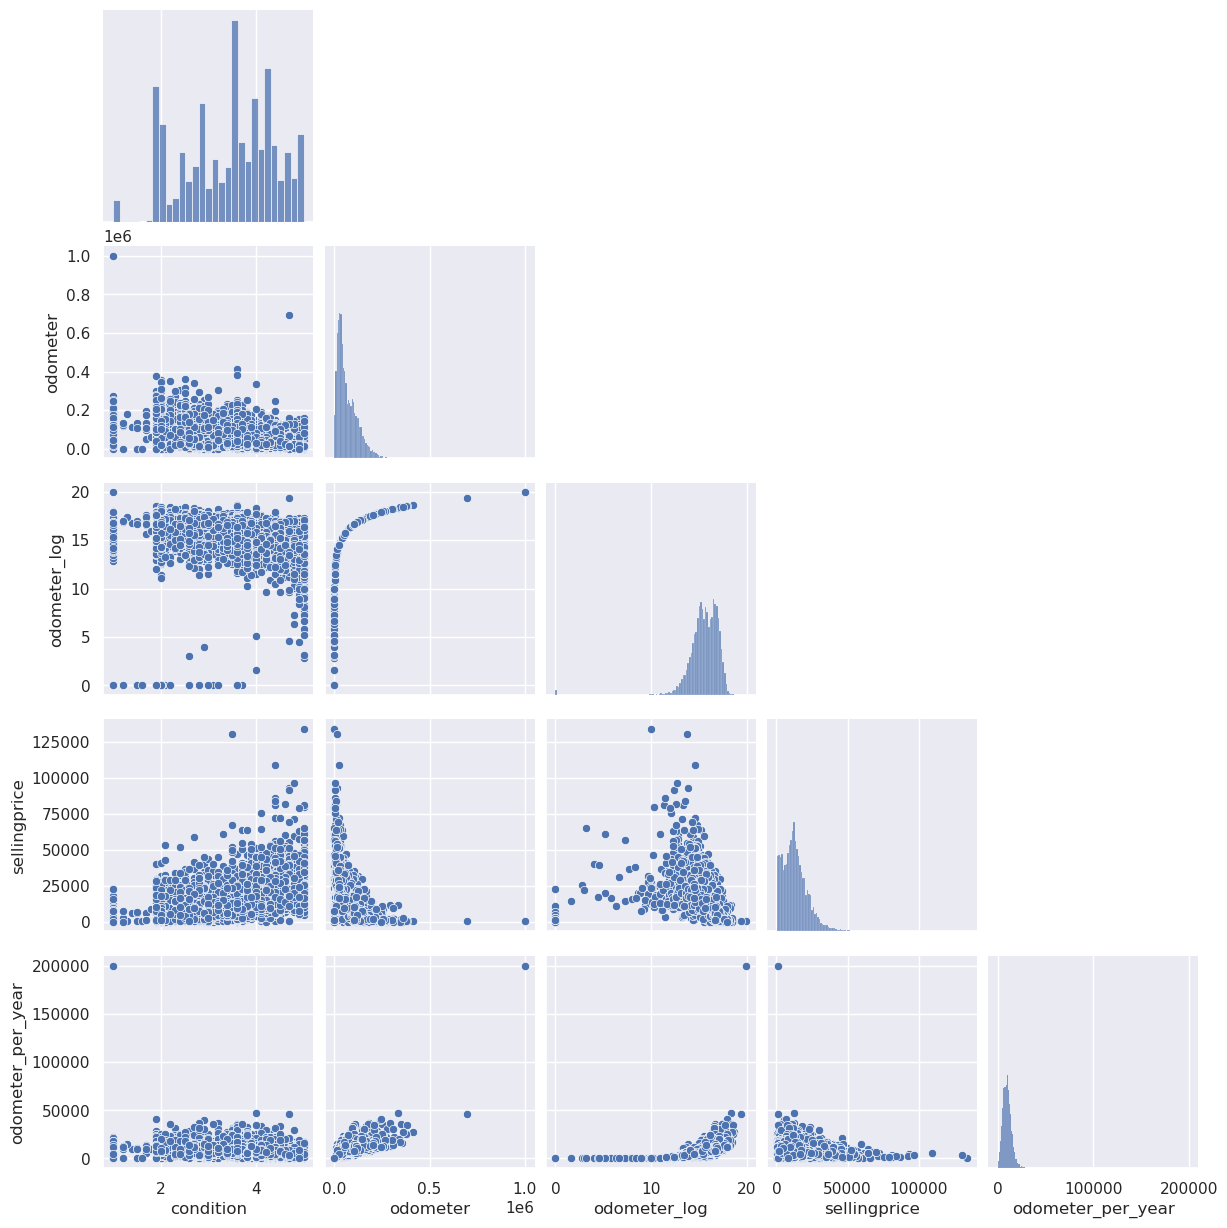

In [100]:
sns.set()
sns.pairplot(numeric_features.loc[:10000,['condition', 'odometer', 'odometer_log',
                                          'sellingprice', 'odometer_per_year']], corner=True)

Из диаграммы видим следующие взаимосвязи:

    1.Взаимосвязь пробега и его производных признаков: логарифма пробега и пробега в год с ценой автомобиля
    2.Взаимосвязь признака состояния с ценой автомобиля

### По году производства

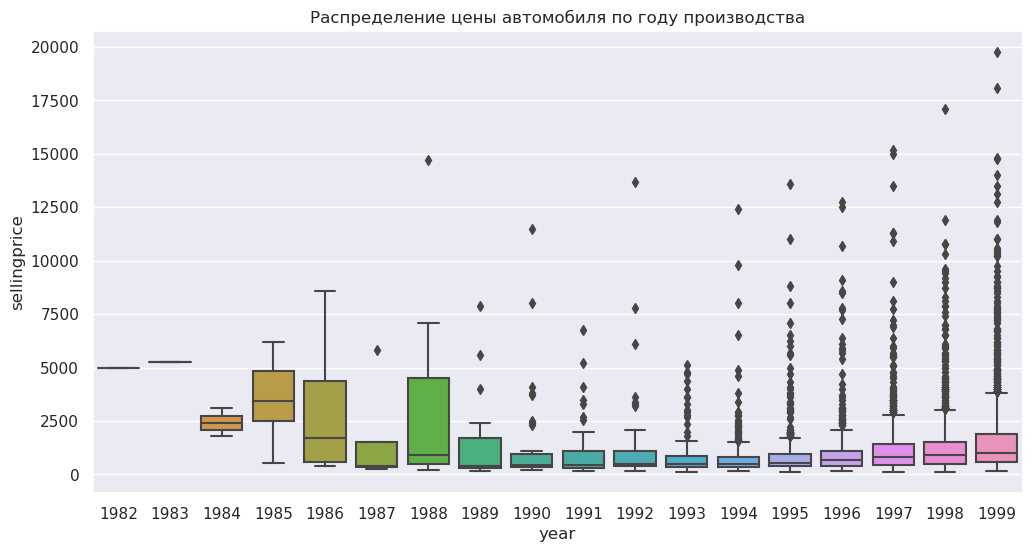

In [101]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(data = numeric_features[numeric_features.year < 2000], x='year', y='sellingprice')
plt.title('Распределение цены автомобиля по году производства')
plt.show()

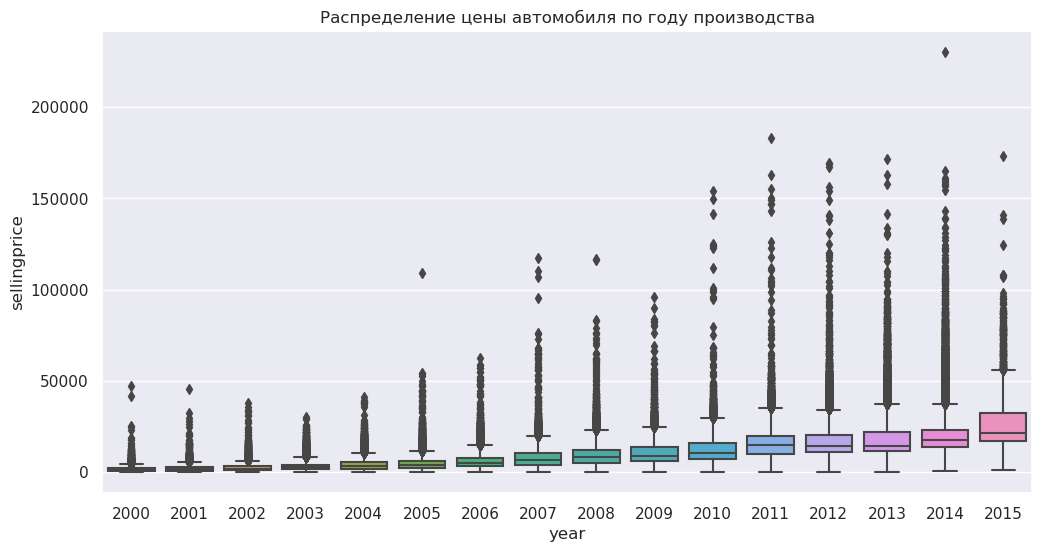

In [102]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(data = numeric_features[numeric_features.year >= 2000], x='year', y='sellingprice')
plt.title('Распределение цены автомобиля по году производства')
plt.show()

Медианная стоимость автомобиля растет от года 

### По дню недели

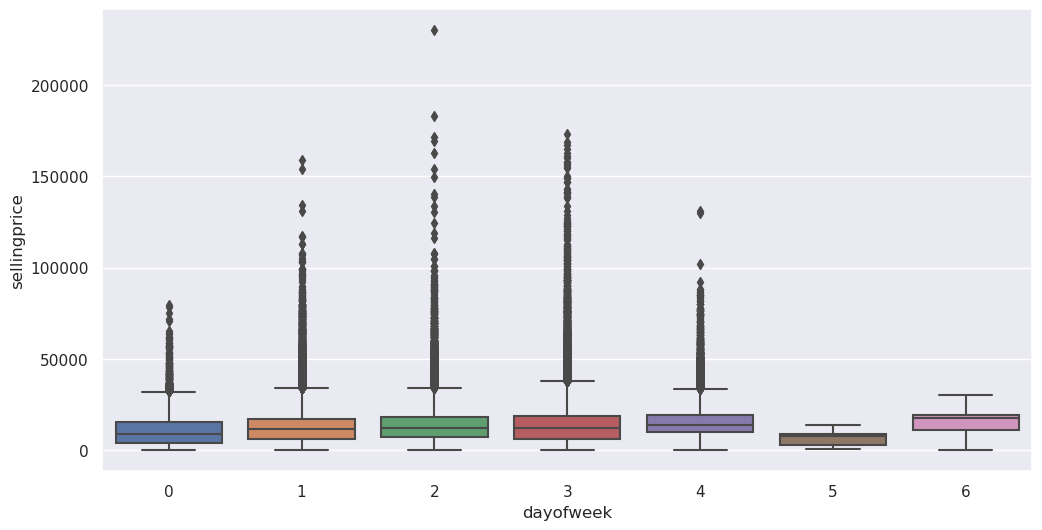

In [103]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(data = numeric_features, x='dayofweek', y='sellingprice')
plt.show()

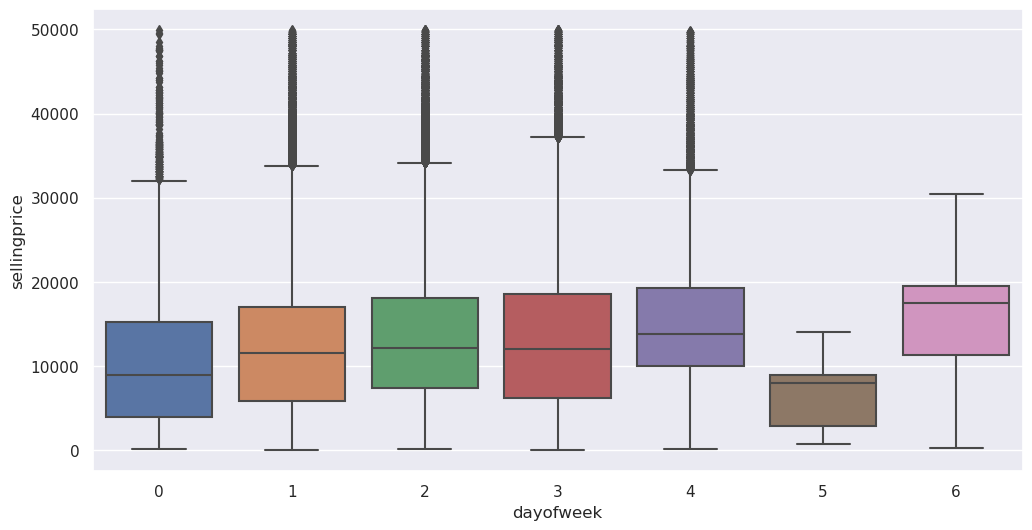

In [104]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(data = numeric_features[numeric_features.sellingprice < 50_000], x='dayofweek', y='sellingprice')
plt.show()

В суббот отличное распределение от других дней недели



### По году продажи

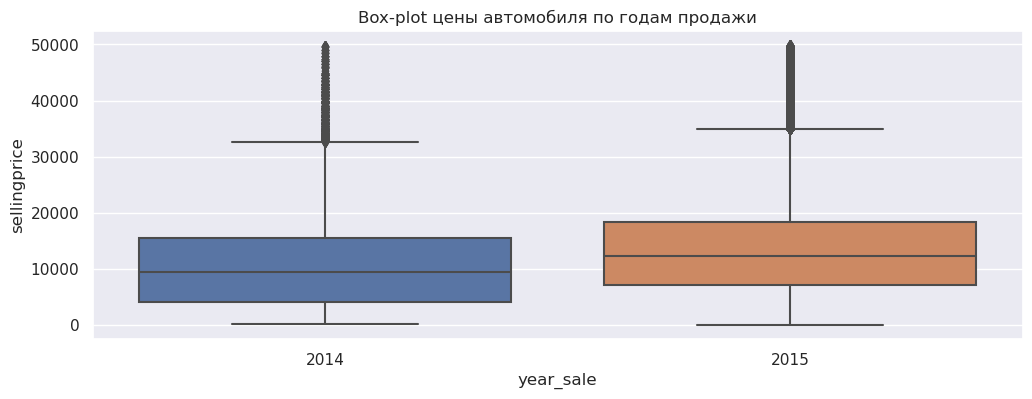

In [105]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(data = numeric_features[numeric_features.sellingprice < 50_000], x='year_sale', y='sellingprice')
ax.set_title('Box-plot цены автомобиля по годам продажи')
plt.show()

Медианная стоимость продажи растет

## 4.3. Категориальные признаки

### Форма кузова автомобиля

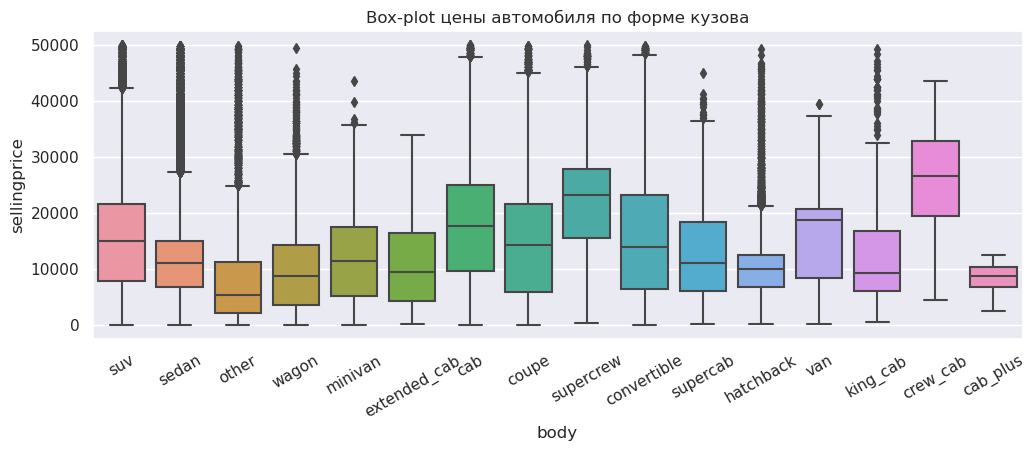

In [106]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[df.sellingprice < 50_000], x='body', y='sellingprice')
ax.set_title('Box-plot цены автомобиля по форме кузова')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

Распределения цены автомобиля в зависимости от формы кузова автомобиля сильно отличаются

### Модель

In [107]:
df.model.value_counts()[df.model.value_counts(normalize=True)>0.01]

altima              15454
f-150               11598
fusion              10247
camry               10001
escape               9520
focus                8231
accord               7238
grand caravan        6494
3 series             6462
impala               6389
explorer             6290
civic                5972
corolla              5868
g sedan              5859
malibu               5751
sonata               5436
maxima               5198
cruze                5111
silverado 1500       5040
elantra              4976
town and country     4816
edge                 4683
rogue                4446
Name: model, dtype: int64

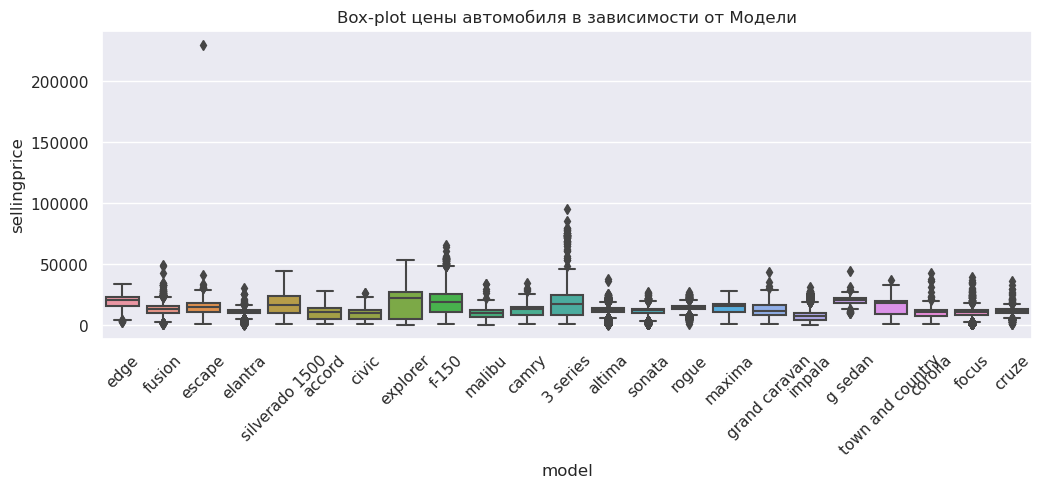

In [108]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[df.model.isin(df.model.value_counts()[df.model.value_counts(normalize=True)>0.01].index)], \
                 x='model', y='sellingprice')
ax.set_title('Box-plot цены автомобиля в зависимости от Модели')
plt.xticks(rotation=45)
plt.show()

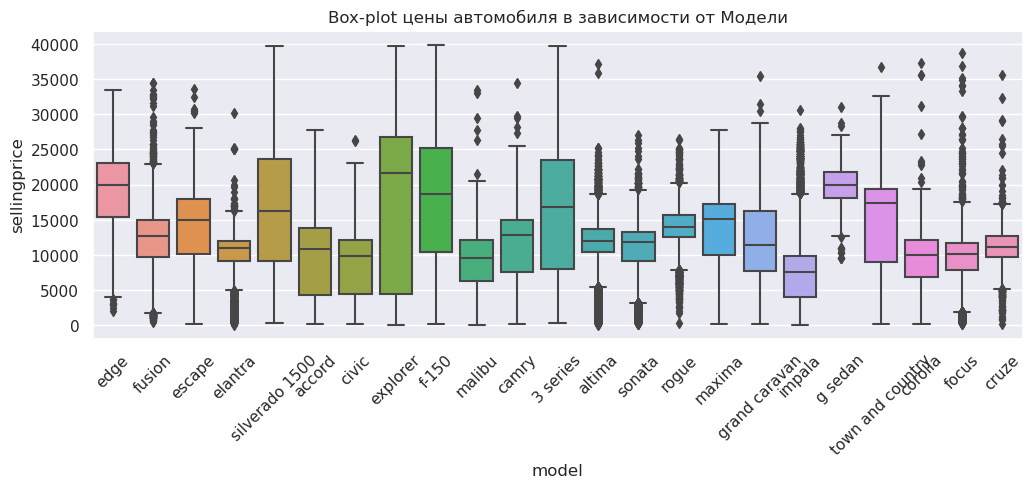

In [109]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[ (df.model.isin(df.model.value_counts()[df.model.value_counts(normalize=True)>0.01].index)) & 
                     (df.sellingprice < 40_000)], \
                 x='model', y='sellingprice')
ax.set_title('Box-plot цены автомобиля в зависимости от Модели')
plt.xticks(rotation=45)
plt.show()

Распределения цены автомобиля в зависимости от Модели очень сильно отличаются, признак скорее всего будет важным при построении моделей

### Трансмиссия

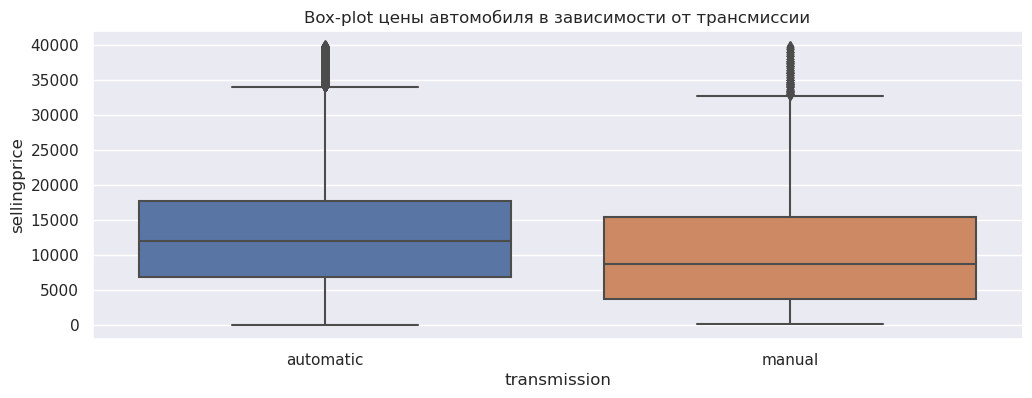

In [110]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[df.sellingprice < 40_000], x='transmission', y='sellingprice')
ax.set_title('Box-plot цены автомобиля в зависимости от трансмиссии')
plt.show()

Распределения цены автомобиля в зависимости от типа трансмиссии не сильно отличаются, признак скорее всего не будет важным при построении моделей



## Интерьер

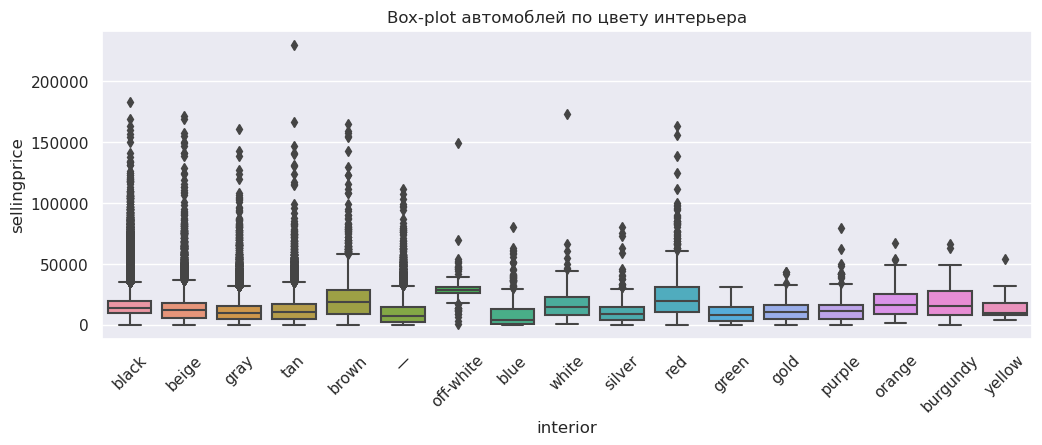

In [111]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df, x='interior', y='sellingprice')
ax.set_title('Box-plot автомоблей по цвету интерьера')
plt.xticks(rotation=45)
plt.show()

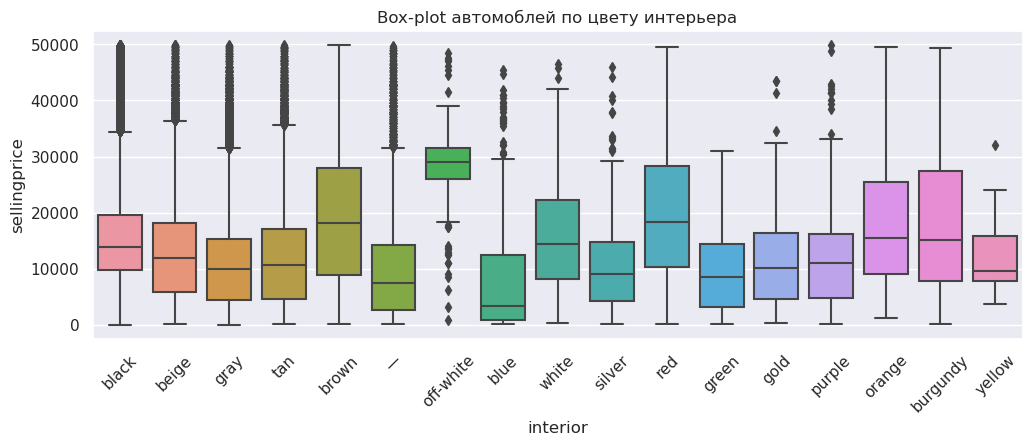

In [112]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[df.sellingprice < 50_000], x='interior', y='sellingprice')
ax.set_title('Box-plot автомоблей по цвету интерьера')
plt.xticks(rotation=45)
plt.show()

Распределения цены в зависимости от цвета интерьера автомобиля достаточно разнообразные, особенно выделяется off-white, где медианная цена выше всех остальных груп



### Цвет автомобиля

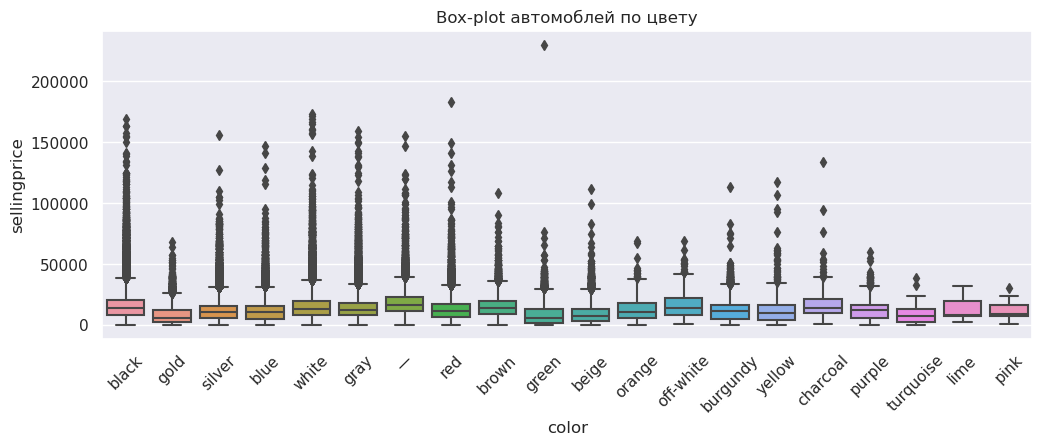

In [113]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df, x='color', y='sellingprice')
ax.set_title('Box-plot автомоблей по цвету')
plt.xticks(rotation=45)
plt.show()

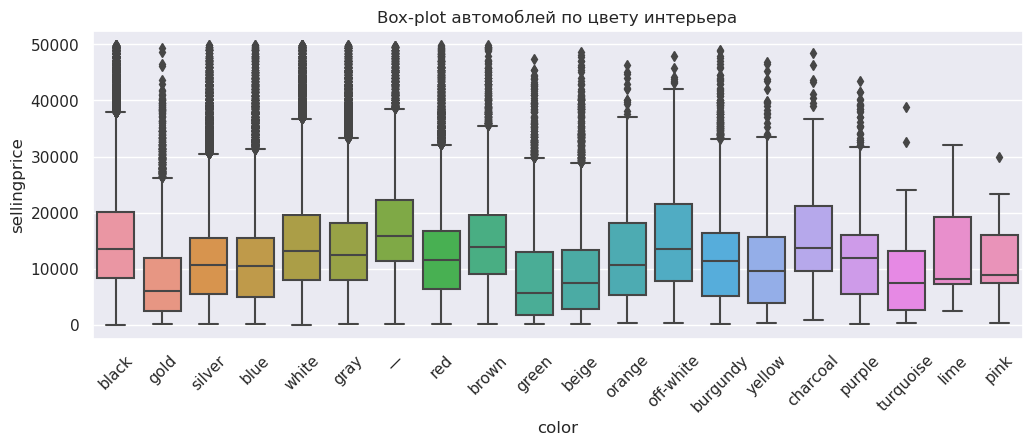

In [114]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(df[df.sellingprice < 50_000], x='color', y='sellingprice')
ax.set_title('Box-plot автомоблей по цвету интерьера')
plt.xticks(rotation=45)
plt.show()

In [115]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate', 'dayofweek', 'year_sale', 'month_sale', 'years_of_car',
       'region', 'country', 'manufacture', 'model_code', 'wheelbase',
       'body_type', 'production_year', 'producation_plant', 'odometer_log',
       'odometer_per_year', 'fin_type', 'expensive_type', 'engine_capacity',
       'engine_type', 'electric', 'four_wheel_drive', 'van', 'trim_clear',
       'seller_cast', 'sellingprice_log'],
      dtype='object')

Распределения цены автомобиля в зависимости от цвета автомобиля достаточно разнообразные, особенно выделяется off-white, где медианная цена выше всех остальных груп


## 4.4. Корреляционный анализ

Так как у нас много категориальных переменных воспользуемся phik библиотекой -
метод базируется на подсчете хи-квадрат статистики.

In [116]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate', 'dayofweek', 'year_sale', 'month_sale', 'years_of_car',
       'region', 'country', 'manufacture', 'model_code', 'wheelbase',
       'body_type', 'production_year', 'producation_plant', 'odometer_log',
       'odometer_per_year', 'fin_type', 'expensive_type', 'engine_capacity',
       'engine_type', 'electric', 'four_wheel_drive', 'van', 'trim_clear',
       'seller_cast', 'sellingprice_log'],
      dtype='object')

In [117]:
phik_overview = df[['year', 'model', 'body', 'transmission', 'state',
                    'condition', 'odometer', 'color', 'interior',
                   'dayofweek', 'month_sale', 'years_of_car', 'region', 'country',
                   'manufacture', 'wheelbase', 'production_year', 'producation_plant',
                    'odometer_log','odometer_per_year', 'fin_type', 'expensive_type',
                    'engine_capacity',  'engine_type', 'electric', 'four_wheel_drive', 'van',
                    'trim_clear', 'seller_cast', 'sellingprice_log']].phik_matrix()

interval columns not set, guessing: ['year', 'condition', 'odometer', 'dayofweek', 'month_sale', 'years_of_car', 'odometer_log', 'odometer_per_year', 'sellingprice_log']


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/tmp/ipykernel_32/3751732151.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


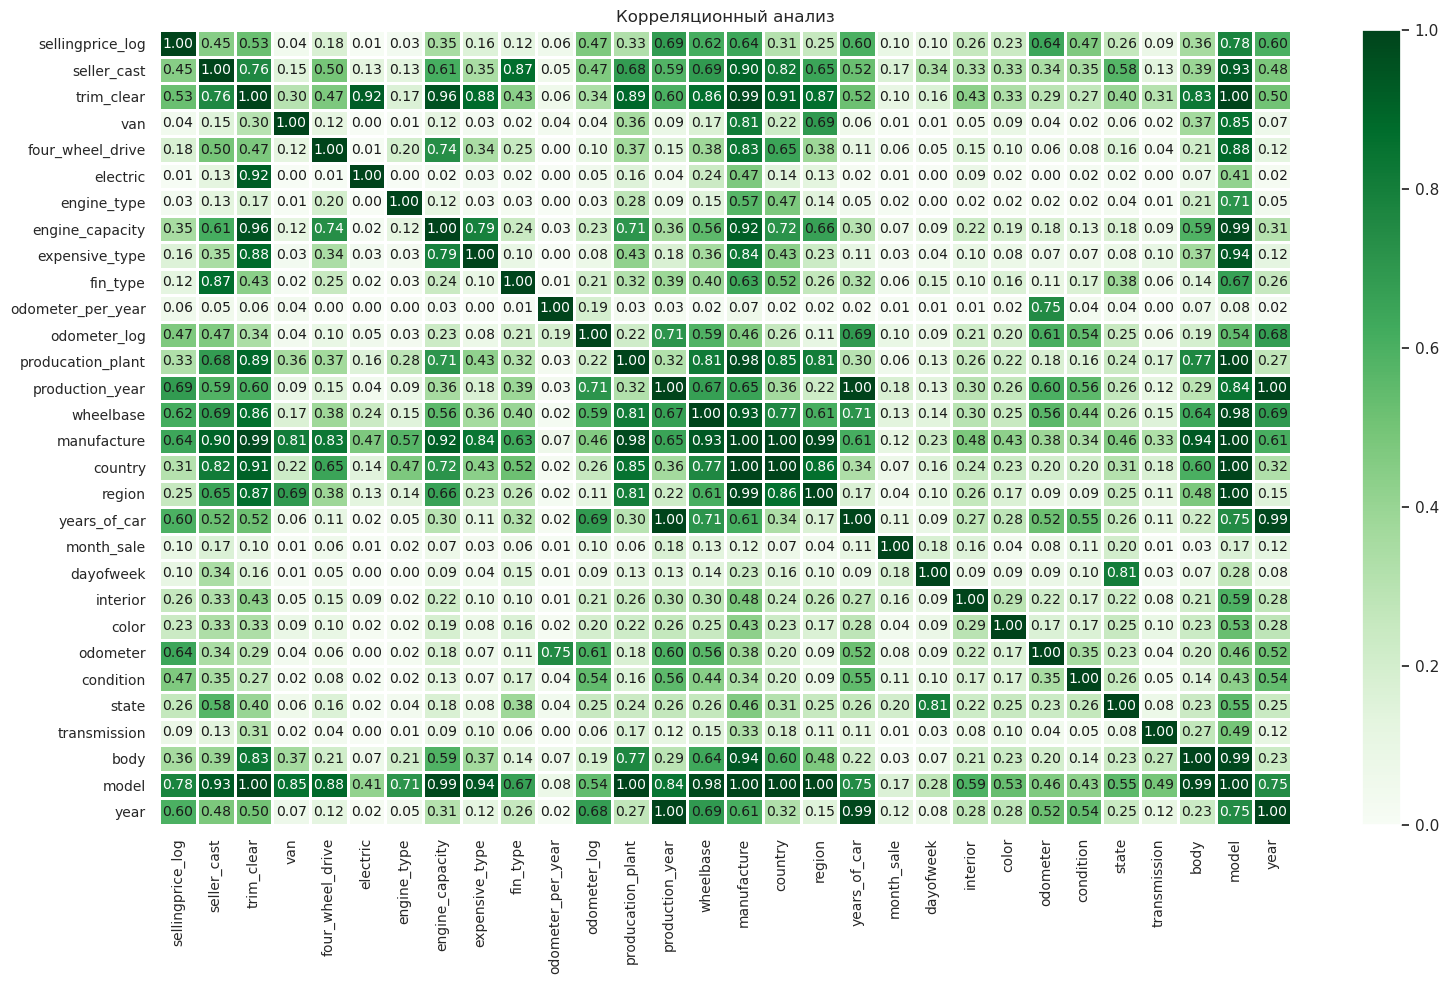

In [118]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 10))
plt.title('Корреляционный анализ')
plt.tight_layout()

Корреляция независимых переменных от зависимой - цены автомобиля, по критерияю хи-квадрат:

In [119]:
phik_overview.sellingprice_log.round(2).sort_values(ascending = False)

sellingprice_log     1.00
model                0.78
production_year      0.69
odometer             0.64
manufacture          0.64
wheelbase            0.62
year                 0.60
years_of_car         0.60
trim_clear           0.53
condition            0.47
odometer_log         0.47
seller_cast          0.45
body                 0.36
engine_capacity      0.35
producation_plant    0.33
country              0.31
state                0.26
interior             0.26
region               0.25
color                0.23
four_wheel_drive     0.18
expensive_type       0.16
fin_type             0.12
dayofweek            0.10
month_sale           0.10
transmission         0.09
odometer_per_year    0.06
van                  0.04
engine_type          0.03
electric             0.01
Name: sellingprice_log, dtype: float64

**По результатам проведенного EDA из наиболее важных признаков можно выделить следующие:**

    - model - модель автомобиля
    - odometer - пробег
    - condition - состояние
    - production_year - год производства
    - manufacture - производитель
    - wheelbase - база
    - years_of_car - лет автомобилю

# 5. Обучаем модели

## 5.1. Признаки для обучения

In [120]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate', 'dayofweek', 'year_sale', 'month_sale', 'years_of_car',
       'region', 'country', 'manufacture', 'model_code', 'wheelbase',
       'body_type', 'production_year', 'producation_plant', 'odometer_log',
       'odometer_per_year', 'fin_type', 'expensive_type', 'engine_capacity',
       'engine_type', 'electric', 'four_wheel_drive', 'van', 'trim_clear',
       'seller_cast', 'sellingprice_log'],
      dtype='object')

In [121]:
df.dtypes[df.dtypes == 'object'].index

Index(['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'color', 'interior', 'seller', 'region', 'country', 'manufacture',
       'model_code', 'wheelbase', 'body_type', 'production_year',
       'producation_plant', 'fin_type', 'expensive_type', 'engine_capacity',
       'engine_type', 'electric', 'four_wheel_drive', 'van', 'trim_clear',
       'seller_cast'],
      dtype='object')

**Отобранные признаки для обучения модели**

In [122]:
cat_features = ['body',
                'model',
                'color',
                'state',
                'interior',
                'country',
                'manufacture',
                'wheelbase',
                'producation_plant',
                'fin_type',
                'expensive_type',
                'four_wheel_drive',
                'engine_capacity',
                'engine_type',
                'seller_cast',
                'trim_clear',
                'electric',
                'van'
               ]

int_features = ['condition',
                'odometer',
                'odometer_per_year',
                'years_of_car',
                'month_sale']

In [123]:
y = ['sellingprice_log']
X = cat_features + int_features
features = X + y

## 5.2. Разбиваем на train и val

In [124]:
# check
df[features].isna().mean() > 0

body                 False
model                False
color                False
state                False
interior             False
country              False
manufacture          False
wheelbase            False
producation_plant    False
fin_type             False
expensive_type       False
four_wheel_drive     False
engine_capacity      False
engine_type          False
seller_cast          False
trim_clear           False
electric             False
van                  False
condition            False
odometer             False
odometer_per_year    False
years_of_car         False
month_sale           False
sellingprice_log     False
dtype: bool

In [125]:
train, val = train_test_split(df[features], train_size=0.80, random_state=RANDOM_STATE, shuffle=True)

In [126]:
train.shape, val.shape

((352188, 24), (88048, 24))

## 5.3. Масштабируем и кодируем признаки

## StandardScaler

In [127]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

scaler = StandardScaler()

train_num_scaled = scaler.fit_transform(train[int_features])
val_num_scaled = scaler.transform(val[int_features])

train_num_scaled = pd.DataFrame(train_num_scaled, columns=train[int_features].columns)
val_num_scaled = pd.DataFrame(val_num_scaled, columns=val[int_features].columns)

### Сategory Encoding

In [128]:
from category_encoders.cat_boost import CatBoostEncoder

#Catboost encoder
encoder = CatBoostEncoder()
  
# Fit encoder and transform the features
train_cat_scaled = encoder.fit_transform(train[cat_features], train[y])
val_cat_scaled = encoder.transform(val[cat_features])

train_cat_scaled = pd.DataFrame(train_cat_scaled, columns=train[cat_features].columns)
val_cat_scaled = pd.DataFrame(val_cat_scaled, columns=val[cat_features].columns)

In [129]:
train_cat_scaled.shape, val_cat_scaled.shape

((352188, 18), (88048, 18))

In [130]:
train_scaled = pd.concat([train_num_scaled, train_cat_scaled], axis=1)
val_scaled = pd.concat([val_num_scaled, val_cat_scaled], axis=1)

## 5.4. LinearRegression (ElasticNet)

In [131]:
params = {'alpha': [0.001, 0.05, 0.01,  0.1, 0.5, 7.0, 10.0, 20]}
model = ElasticNet(l1_ratio=0.5, random_state=RANDOM_STATE)

In [132]:
grid_cv_model = GridSearchCV(estimator=model,
                             param_grid=params,
                             scoring='neg_root_mean_squared_error',
                             cv=3,
                             return_train_score=True,
                             verbose=1,
                             n_jobs=-1)

grid_cv_model.fit(train_scaled, train[y])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=ElasticNet(random_state=123), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.05, 0.01, 0.1, 0.5, 7.0, 10.0, 20]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [133]:
model = grid_cv_model.best_estimator_

In [134]:
mean_absolute_error(np.exp(val[y]), np.exp(model.predict(val_scaled))), \
    mean_absolute_percentage_error(np.exp(val[y]), np.exp(model.predict(val_scaled)))

(3240.815549520873, 0.3106679798327447)

In [135]:
score_list = list()
score_list.append(('ElasticNet', 'mape', mean_absolute_percentage_error(np.exp(val[y]), np.exp(model.predict(val_scaled)))))

**Метрика MAPE для ElasticNet:**



In [136]:
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,ElasticNet,mape,0.310668


## 5.5. Random Forest

In [137]:
params = {'max_depth': 15,
          'n_estimators': 275,
          'min_samples_leaf': 2,
          'n_jobs': -1}

model = RandomForestRegressor(random_state = RANDOM_STATE, verbose=1, **params)

In [138]:
model.fit(train_scaled, np.ravel(train[y]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 15.1min finished


RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=275,
                      n_jobs=-1, random_state=123, verbose=1)

In [139]:
mean_absolute_error(np.exp(val[y]), np.exp(model.predict(val_scaled))), \
    mean_absolute_percentage_error(np.exp(val[y]), np.exp(model.predict(val_scaled)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    1.7s finished


(1578.9555932801284, 0.1767973756115795)

In [140]:
score_list.append(('RandomForestRegressor', 'mape', mean_absolute_percentage_error(np.exp(val[y]), \
                                                                                   np.exp(model.predict(val_scaled)))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    1.7s finished


**Метрика MAPE для Random Forest:**



In [141]:
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,ElasticNet,mape,0.310668
1,RandomForestRegressor,mape,0.176797


## 5.6. CatBoost Regression

In [142]:
train_pool = Pool(data=train[X],
                  label=train[y],
                  cat_features = cat_features)

validation_pool = Pool(data=val[X],
                       label=val[y],
                       cat_features = cat_features)


params = {'iterations': 2000,
          'learning_rate': 0.5,
          'l2_leaf_reg': 20,
          'loss_function': 'RMSE',
          'verbose': False,
          'custom_metric': ['MAPE'],
          'eval_metric': 'MAPE',
          'task_type': 'CPU',
          'max_depth': 6}


model = CatBoostRegressor(
                        **params,
                        random_seed=RANDOM_STATE
                        )

model.fit(train_pool,
          eval_set=validation_pool,
          verbose=50,
          early_stopping_rounds=50,
          plot=True,
          use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0532717	test: 0.0532069	best: 0.0532069 (0)	total: 939ms	remaining: 31m 16s
50:	learn: 0.0193993	test: 0.0188378	best: 0.0188378 (50)	total: 44.8s	remaining: 28m 32s
100:	learn: 0.0177231	test: 0.0173241	best: 0.0173241 (100)	total: 1m 28s	remaining: 27m 43s
150:	learn: 0.0169725	test: 0.0166641	best: 0.0166641 (150)	total: 2m 11s	remaining: 26m 55s
200:	learn: 0.0165268	test: 0.0162883	best: 0.0162883 (200)	total: 2m 54s	remaining: 26m 5s
250:	learn: 0.0161836	test: 0.0160067	best: 0.0160067 (250)	total: 3m 39s	remaining: 25m 26s
300:	learn: 0.0159243	test: 0.0158142	best: 0.0158142 (300)	total: 4m 23s	remaining: 24m 47s
350:	learn: 0.0157233	test: 0.0156754	best: 0.0156754 (350)	total: 5m 7s	remaining: 24m 3s
400:	learn: 0.0155366	test: 0.0155425	best: 0.0155425 (400)	total: 5m 51s	remaining: 23m 20s
450:	learn: 0.0153769	test: 0.0154480	best: 0.0154480 (450)	total: 6m 35s	remaining: 22m 37s
500:	learn: 0.0152517	test: 0.0153732	best: 0.0153732 (500)	total: 7m 19s	remaini

In [143]:
model.get_params()

{'iterations': 2000,
 'learning_rate': 0.5,
 'l2_leaf_reg': 20,
 'loss_function': 'RMSE',
 'random_seed': 123,
 'verbose': False,
 'custom_metric': ['MAPE'],
 'eval_metric': 'MAPE',
 'task_type': 'CPU',
 'max_depth': 6}

In [144]:
model.best_score_

{'learn': {'MAPE': 0.01360078277407556, 'RMSE': 0.18286960397457291},
 'validation': {'MAPE': 0.014769277206785418, 'RMSE': 0.20575175548500454}}

In [145]:
mean_absolute_error(np.exp(val[y]), np.exp(model.predict(val[X]))), \
    mean_absolute_percentage_error(np.exp(val[y]), np.exp(model.predict(val[X])))

(1155.6122039357067, 0.13252464199487976)

**Метрика MAPE для CatBoost:**



In [146]:
score_list.append(('CatBoost', 'mape', mean_absolute_percentage_error(np.exp(val[y]), np.exp(model.predict(val)))))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,ElasticNet,mape,0.310668
1,RandomForestRegressor,mape,0.176797
2,CatBoost,mape,0.132525


**Feature importance**

In [147]:
t = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': train[X].columns}).sort_values(by='feature_importance', ascending=False)

t

,feature_importance,feature_names
21,18.241976,years_of_car
19,14.363365,odometer
6,12.105533,manufacture
7,11.259529,wheelbase
18,10.158542,condition
0,9.541931,body
1,8.016107,model
5,4.540627,country
8,4.047336,producation_plant
15,1.703461,trim_clear


In [148]:
# GS
# full_pull = Pool(data=df[X], label=df[y], cat_features = cat_features)

# params = {"iterations": 2000,
#           "eval_metric": "MAPE",
#           "loss_function": "RMSE",
#           "verbose": False,
#           "custom_metric": ['MAPE'],
#           "task_type": "GPU"
# }

# grid = {
#     'learning_rate': [0.4, 0.5, 0.7],
#     'depth':[5, 6],
#     'l2_leaf_reg': [10, 20, 30]
# }

# model = CatBoostRegressor(
#     **params,
#     random_seed=RANDOM_STATE
# )

# grid_search_results = model.grid_search(grid, full_pull, shuffle=True, cv=3, verbose=10, plot=True)

## 5.7. Keras

In [150]:
keras.utils.set_random_seed(RANDOM_STATE)

model = keras.models.Sequential()
model.add(keras.layers.Dense(units=64, input_dim=train_scaled.shape[1], activation='relu'))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(1))

In [151]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

In [152]:
callback = callbacks.EarlyStopping(monitor='loss', patience=10)

In [153]:
ep_num = 50
verb_num = 1
batch_num = 2048

In [154]:
model.fit(train_scaled,
              train[y],
              epochs=ep_num,
              verbose=verb_num,
              batch_size=batch_num,
              callbacks=[callback],
              validation_data=(val_scaled, val[y])
             )

Epoch 1/50
172/172 [==============================] - 2s 7ms/step - loss: 0.7044 - val_loss: 0.1893
Epoch 2/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1803 - val_loss: 0.1676
Epoch 3/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1682 - val_loss: 0.1613
Epoch 4/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1664 - val_loss: 0.1547
Epoch 5/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1667 - val_loss: 0.1637
Epoch 6/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1672 - val_loss: 0.1562
Epoch 7/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1592 - val_loss: 0.1467
Epoch 8/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1517 - val_loss: 0.1423
Epoch 9/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1522 - val_loss: 0.1446
Epoch 10/50
172/172 [==============================] - 1s 5ms/step - loss: 0.1458 - val_loss: 0.1317

In [155]:
prediction = model.predict(val_scaled)

2752/2752 [==============================] - 3s 1ms/step


In [156]:
mean_absolute_error(np.exp(val[y]), np.exp(prediction)), \
    mean_absolute_percentage_error(np.exp(val[y]), np.exp(prediction))

(3001.8421086124695, 0.2712603302256205)

In [157]:
score_list.append(('Keras', 'mape', mean_absolute_percentage_error(np.exp(val[y]), np.exp(prediction))))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,ElasticNet,mape,0.310668
1,RandomForestRegressor,mape,0.176797
2,CatBoost,mape,0.132525
3,Keras,mape,0.271260


# 6. Выводы

В итоге получили следующую матрицу

In [158]:
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,ElasticNet,mape,0.310668
1,RandomForestRegressor,mape,0.176797
2,CatBoost,mape,0.132525
3,Keras,mape,0.271260


**По результатам построения моделей лучшей моделью оказался CatBoost c метриков в 13.25% на валидационной выборке, бустинговый метод в данной задаче можно считать приоритетным при использовании.**


**По результатам проведенной работы что можно ещё улучшить, можно продолжить работу с текстовыми признаками trim и seller, повычленять различную полезную информацию, также попробовать ещё убрать оставшиеся низкоинформативные признаки и пообучать модели, можно попробовать стэкинг из нескольких алгоритмов.**

**Итоговая важность признаков на CatBoost:**

In [159]:
t

,feature_importance,feature_names
21,18.241976,years_of_car
19,14.363365,odometer
6,12.105533,manufacture
7,11.259529,wheelbase
18,10.158542,condition
0,9.541931,body
1,8.016107,model
5,4.540627,country
8,4.047336,producation_plant
15,1.703461,trim_clear
